#Домашнее задание 1. Вариант 2





In [ ]:
# Загружаем датасет.
!wget https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Wireless_v1_00.tsv.gz

--2021-10-10 18:57:33--  https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Wireless_v1_00.tsv.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.167.112
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.167.112|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1704713674 (1.6G) [application/x-gzip]
Saving to: ‘amazon_reviews_us_Wireless_v1_00.tsv.gz’

amazon_reviews_us_W 100%[===================>]   1.59G  82.6MB/s    in 22s     

2021-10-10 18:57:56 (74.3 MB/s) - ‘amazon_reviews_us_Wireless_v1_00.tsv.gz’ saved [1704713674/1704713674]



In [ ]:
# Распаковываем.
!gunzip amazon_reviews_us_Wireless_v1_00.tsv.gz

In [ ]:
# Читаем датасет.
import pandas as pd

df = pd.read_csv('amazon_reviews_us_Wireless_v1_00.tsv', sep='\t', error_bad_lines=False, nrows=100000)

b'Skipping line 51163: expected 15 fields, saw 22\n'
b'Skipping line 77018: expected 15 fields, saw 22\nSkipping line 97528: expected 15 fields, saw 22\n'


In [ ]:
df.head(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,16414143,R3W4P9UBGNGH1U,B00YL0EKWE,852431543,LG G4 Case Hard Transparent Slim Clear Cover f...,Wireless,2,1,3,N,Y,"Looks good, functions meh",2 issues - Once I turned on the circle apps ...,2015-08-31
1,US,50800750,R15V54KBMTQWAY,B00XK95RPQ,516894650,Selfie Stick Fiblastiq&trade; Extendable Wirel...,Wireless,4,0,0,N,N,A fun little gadget,"I’m embarrassed to admit that until recently, ...",2015-08-31
2,US,15184378,RY8I449HNXSVF,B00SXRXUKO,984297154,Tribe AB40 Water Resistant Sports Armband with...,Wireless,5,0,0,N,Y,Five Stars,Fits iPhone 6 well,2015-08-31
3,US,10203548,R18TLJYCKJFLSR,B009V5X1CE,279912704,RAVPower® Element 10400mAh External Battery US...,Wireless,5,0,0,N,Y,Great charger,Great charger. I easily get 3+ charges on a S...,2015-08-31
4,US,488280,R1NK26SWS53B8Q,B00D93OVF0,662791300,Fosmon Micro USB Value Pack Bundle for Samsung...,Wireless,5,0,0,N,Y,Five Stars,Great for the price :-),2015-08-31


In [ ]:
# Используем библиотеки для токенизации и лемматизации.
import nltk
from nltk.stem import WordNetLemmatizer

nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Токенизируем и лемматизируем.

lemmatizer = WordNetLemmatizer()

df['review_body'] = df['review_body'].map(lambda x: " ".join([lemmatizer.lemmatize(y) for y in nltk.word_tokenize(str(x).lower()) if y not in [',', '.', '!']]))

В качестве экспрессива я решил выбрать слово "crap", поскольку дальнейший датасет относится к технике, потому оно может часто фигурировать в отзывах.
Скорее всего автор ревью заинтересован в том, чтобы на основе его отзыва сформировали мнение о том, покупать ли продукт или нет. По этой причине использование "crap" может в большинстве случаев однозначно определить, что покупать не стоит. Например, в ревью автор может сказать следующее: "This phone is the crap so you shouldn't buy it."
Также при отрицательном опыте покупки вероятнее всего покупатель всё-таки будет искреннен в своём использовании экспрессива.


Я предполагаю, что экспрессив будет иметь J-образную отзеркаленную форму. Это так, поскольку логично предположить, что пользователи с хорошей техникой будут меньше всего использовать "crap", потому что она всё-таки работает. В отзывах на единицу наоборот как раз будет часто фигурировать данный экспрессив. Однако могут быть единичные случаи, когда "crap" будет использоваться в положительном контексте. Например, "phone is good but micro is crap", "phone is better than previous crap".

In [ ]:
# Экспрессив, на который будет опираться дальнейшее исследование.
word = 'crap'

In [ ]:
# Создание подкорпуса с исследуемым экспрессивом.
sub_df = df.loc[df['review_body'].str.contains(word)]

In [ ]:
# Метод, подсчитывающий количество экспрессивов по рейтингу.
def get_rating_count(rating, word, df):
  return sum(df.loc[df['star_rating'] == rating]['review_body'].str.count(word))

In [ ]:
# Метод, подсчитывающий количество токенов с указанной длиной n по рейтингу в подкорпусе.
def get_count_ratings(rating, df, n):
  return sum(list(map(lambda x: count_words_n_length(x, n), df.loc[df['star_rating'] == rating]['review_body'].str.split(' '))))

In [ ]:
# Метод, подсчитывающий количество токенов.
def count_words_n_length(sentence, n):
  count = 0
  for word in sentence:
    if len(word) == n:
      count += 1
  return count

In [ ]:
import math

log_odds = {}

# Вычисление натуральных логарифмов по рейтингу.
for i in range(1, 6):
  countRx = get_rating_count(i, word, sub_df)
  countR = get_count_ratings(i, df, len(word))
  print(countR, ' ', countRx)

  log_odds[i] = math.log(countRx / (countR - countRx))
  print(f'Rating: {i}, log: {log_odds[i]}')

95200   293
Rating: 1, log: -5.780480134715264
53572   38
Rating: 2, log: -7.250486085322886
72338   28
Rating: 3, log: -7.856513200993794
142226   43
Rating: 4, log: -8.103670123581376
401523   85
Rating: 5, log: -8.460157123032955


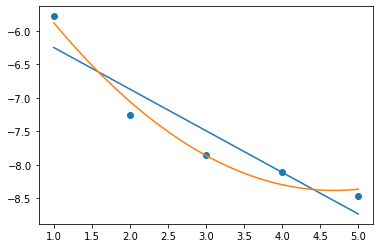

In [ ]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline

# Формирование входных данных для регрессионной модели.
x = list(range(1, 6))
X = np.array(x).reshape(-1, 1)
y = np.array(list(log_odds.values()))

# Создание пайплайна для регрессии и обучение модели.
polyreg = make_pipeline(PolynomialFeatures(degree=1), LinearRegression())
polyreg.fit(X, y)

xnew = np.linspace(1, 5, 500)  

# Сглаживание полученной регрессионной модели.
spl = make_interp_spline(x, polyreg.predict(X), k=2)
power_smooth = spl(xnew)

plt.figure()
plt.scatter(x, y)
plt.plot(xnew, power_smooth)

# Создание пайплайна для регрессии с квадратичным полиномом и обучение модели.
polyreg = make_pipeline(PolynomialFeatures(degree=2), LinearRegression())
polyreg.fit(X, y)

xnew = np.linspace(1, 5, 500)  

# Сглаживание полученной регрессионной модели.
spl = make_interp_spline(x, polyreg.predict(X), k=2)
power_smooth = spl(xnew)

plt.plot(xnew, power_smooth)

plt.show()

Квадратичная регрессия показывает наилучшим образом тенденцию, хотя и линейная регрессия также в целом выражает её. Другая ситуация была бы в том случае, когда точки располагались нелинейно, в таком случае линейная регрессия бы плохо описывала интенсивность.


Как видно по графику, гипотеза подтвердилась. Профиль получился J-образный, но в другую сторону. По мере увеличения рейтинга интенсивность использования экспрессива "crap" уменьшается.

In [ ]:
pd.set_option('display.max_colwidth', 165)

# Смотрим содержание каждого комментария по рейтингу.
for i in range(1, 6):
  print('--------------------' + str(i) + ' star rating--------------------')
  print(sub_df.loc[df['review_body'].str.contains(word)].loc[df['star_rating'] == i]['review_body'].head(10))

--------------------1 star rating--------------------
835                                                                                                                                                             chinese crap
1255                                                                                                                                       piece of crap just for decoration
1626    this shield is pretty crappy for the nexus took me awhile to get it installed then it doe n't cover much of the phone i ended up getting an intelliamor pro for t...
1751    crap ... cheaply made ... .had scratch on it and it only cobers the back and side provides no protection for the screen like a case is suppose to do in fact it i...
1769                                                                                                                                   blew in the first month complete crap
1791                                           this thing crapped out really earl

In [ ]:
def get_avg_words_per_rating(rating, df):
  return sum(list(map(lambda x: len(x), df.loc[df['star_rating'] == rating]['review_body'].str.split(' ')))) / len(df.loc[df['star_rating'] == rating])

In [ ]:
# Смотрим среднее количество слов в отзыве по каждому рейтингу.
for i in range(1, 6):
  avg = get_avg_words_per_rating(i, sub_df)
  print(f"Avg words per {i} star is {avg}")

Avg words per 1 star is 54.40425531914894
Avg words per 2 star is 99.44736842105263
Avg words per 3 star is 318.7916666666667
Avg words per 4 star is 258.15
Avg words per 5 star is 112.09638554216868


Среди интересных находок при исследовании корпуса нашлось то, что некоторые люди ставят оценку 5 баллов даже при том условии, что у техники не всё отлично. Пример такого отзыва:
good mic but the battery not worth a crap.

Также нейтральные отзывы (рейтинг 3 или 4) в среднем имеют больше слов, чем отзывы с другими рейтингами. Вероятно, в нейтральных обзорах стараются более объективно подойти к покупке. В положительных или негативных отзывах вероятнее используют чаще экспрессивы, поскольку они ёмко характеризуют вещь.